# Einfache Analyse von deutschen Schlagzeilen

Die Daten für dieses Projekt wurde selbst gesammelt und bilden jeweils den Zeitpunkt und den Text einer Schlagzeile da. Der Zeitraum erstreckt sich über einen Tag.

### MODULE

In [43]:
import pandas as pd
import spacy
import json
import numpy as np
import matplotlib.pyplot as plt

from spacy_sentiws import spaCySentiWS
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from collections import Counter

### VOREINSTELLUNGEN

- Laden einer Liste mit 620 deutschen *Stopwords*
- Ausgabe Erweiterung für `pandas.DataFrame`s in *Jupyter Notebooks*

In [2]:
with open("stopwords-de.json") as f:
    STOPWORDS = json.load(f)

pd.set_option('display.max_colwidth', None)

### EINLESEN

Beim Einlesen der `csv` Datei nutzen wir die Parameter
- `index_col` damit die Spalte `datetime` als Index gesetzt wird
- `parse_dates` um Zeiten in ein `Datetime` Datentyp umzuwandeln

In [3]:
df = pd.read_csv("schlagzeilen.csv", index_col="datetime", parse_dates=True)
df

,text
datetime,
2020-10-05 21:00:02,nach US-Open-Skandal - Djokovic trifft schon wieder den Linienrichter!
2020-10-05 16:25:08,Angriff vor Hamburger Synagoge: Tatverdächtiger kommt in Psychatrie
2020-10-05 11:10:01,Staatskapelle Dresden im ZDF-Silvesterkonzert
2020-10-05 17:00:04,Was gilt für Reisen aus Risikogebieten in den Herbstferien?
2020-10-05 04:30:02,"Nächste Lewandowski-Gala: ""Absoluter Torjäger"""
...,...
2020-10-05 19:55:02,In Markt Schwaben: Kommunalunternehmen legt Bilanzen offen
2020-10-05 12:55:02,Schadenfreude - das ist Deutsch für Weltbürger
2020-10-05 11:10:01,Straußenfleisch ist hierzulande bislang eher wenig gefragt


Überprüfen ob
- der Index vom Typ `DatetimeIndex` ist
- ob wir fehlende Werte in der Spalte `text` haben

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1739 entries, 2020-10-05 21:00:02 to 2020-10-05 06:45:02
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1739 non-null   object
dtypes: object(1)
memory usage: 27.2+ KB


Daten aufsteigend nach den Zeiten im Index sortieren

In [5]:
df = df.sort_index()
df

,text
datetime,
2020-10-05 00:00:02,Bundestrainer startet Vorbereitung: Länderspiel-Dreierpack
2020-10-05 00:05:02,"""Anne Will"" zur Corona-Infektion des US-Präsidenten : Der Trump-Unterstützer - das seltsame, exotische Tierchen"
2020-10-05 00:05:03,Modeschöpfer Kenzo an Covid-19 gestorben
2020-10-05 00:10:02,Wegen Corona-Krise: Weltbankchef fordert wegen Schuldenerlass für ärmste Länder
2020-10-05 00:15:01,FC Nürnberg empfängt SV Darmstadt im Zweitliga-Montagsspiel
...,...
2020-10-05 23:35:02,Software-Entwickler McAfee in Spanien verhaftet
2020-10-05 23:40:01,Minister und Kammern informieren über Grippeschutzimpfung
2020-10-05 23:45:02,Trump zurück im Weißen Haus


### SPACY PIPELINE

Deutschen Sprachkorpus laden

In [6]:
nlp = spacy.load("de_core_news_lg")

Damit *stopwords* erkannt werden laden wir den `SentiWS_v2` der Universität Leipzig

In [7]:
for w in STOPWORDS:
    nlp.vocab[w].is_stop = True
sentiws = spaCySentiWS(sentiws_path="SentiWS_v2")
nlp.add_pipe(sentiws)

Text wird jetzt durch die komplette *pipeline* geladen und ist dannach vorbereitet

In [8]:
df["text"] = list(nlp.pipe(df["text"].to_list()))
nlp.pipeline

[('tagger', <spacy.pipeline.pipes.Tagger at 0x12d5b8b80>),
 ('parser', <spacy.pipeline.pipes.DependencyParser at 0x12d5ab280>),
 ('ner', <spacy.pipeline.pipes.EntityRecognizer at 0x12d5ab220>),
 ('spaCySentiWS', <spacy_sentiws.spaCySentiWS at 0x1366e06a0>)]

### PREPROCESSING

1. Stopwörter entfernen
2. Satzzeichen und Ähnliches entfernen
3. *+* entfernen
4. Zahlen entfernen
5. Bezeichnungen für Zahlen entfernen
6. Zusätzliche *whitespaces* entfernen
7. Lemma (Grundform) bilden
8. in Kleinbuchstaben umwandeln

In [9]:
def clean(doc):
    doc = [token for token in doc if not token.is_stop]
    doc = [token for token in doc if not token.is_punct]
    doc = [token for token in doc if not token.text == "+"]
    doc = [token for token in doc if not token.is_digit]
    doc = [token for token in doc if not token.like_num]
    doc = [token for token in doc if not token.is_space]
    doc = [token.lemma_ for token in doc]
    doc = [w.lower() for w in doc]
    return doc


df["preprocessed"] = df["text"].apply(clean)
df

,text,preprocessed
datetime,,
2020-10-05 00:00:02,"(Bundestrainer, startet, Vorbereitung, :, Länderspiel-Dreierpack)","[bundestrainer, starten, vorbereitung, länderspiel-dreierpack]"
2020-10-05 00:05:02,"("", Anne, Will, "", zur, Corona-Infektion, des, US-Präsidenten, , :, Der, Trump-Unterstützer, -, das, seltsame, ,, exotische, Tierchen)","[anne, corona-infektion, us-präsidenten, trump-unterstützer, seltsam, exotische, tierchen]"
2020-10-05 00:05:03,"(Modeschöpfer, Kenzo, an, Covid-19, gestorben)","[modeschöpfer, kenzo, covid-19, sterben]"
2020-10-05 00:10:02,"(Wegen, Corona-Krise, :, Weltbankchef, fordert, wegen, Schuldenerlass, für, ärmste, Länder)","[corona-krise, weltbankchef, fordern, schuldenerlass, arm, land]"
2020-10-05 00:15:01,"(FC, Nürnberg, empfängt, SV, Darmstadt, im, Zweitliga-Montagsspiel)","[fc, nürnberg, empfangen, sv, darmstadt, zweitliga-montagsspiel]"
...,...,...
2020-10-05 23:35:02,"(Software-Entwickler, McAfee, in, Spanien, verhaftet)","[software-entwickler, mcafee, spanien, verhaften]"
2020-10-05 23:40:01,"(Minister, und, Kammern, informieren, über, Grippeschutzimpfung)","[minister, kammer, informieren, grippeschutzimpfung]"
2020-10-05 23:45:02,"(Trump, zurück, im, Weißen, Haus)","[trump, weiße, haus]"


### ALLGEMEINE ERKENNTNISSE

Wie viele Schlagzeilen haben wir in unserem Datensatz?

In [10]:
df.shape[0]

1739

Welches ist die älteste Schlagzeile?

In [11]:
df.head(1)

,text,preprocessed
datetime,,
2020-10-05 00:00:02,"(Bundestrainer, startet, Vorbereitung, :, Länderspiel-Dreierpack)","[bundestrainer, starten, vorbereitung, länderspiel-dreierpack]"


Welches ist die aktuellste Schlagzeile?

In [12]:
df.tail(1)

,text,preprocessed
datetime,,
2020-10-05 23:50:01,"(Senat, diskutiert, über, Kita-Plätze, und, Corona-Maßnahmen)","[senat, diskutieren, kita-plätze, corona-maßnahmen]"


### SENTIMENT ANALYSE

Bei der *Sentiment Analyse* wird jeden Wort ein Wert zwischen `-1` (sehr negativ) bis `+1` (sehr positiv) zugeordnet. Wenn man daraus das *Produkt* aus allen Wrötern eines Satzes bildet ist das Resultat der Sentiment.

In [13]:
def compute_sentiment(doc):
    sentiments = [token._.sentiws for token in doc if token._.sentiws]
    if sentiments:
        return np.prod(sentiments)
    else:
        return np.nan
        

df["sentiment"] = df["text"].apply(compute_sentiment)
df[["text", "sentiment"]]

,text,sentiment
datetime,,
2020-10-05 00:00:02,"(Bundestrainer, startet, Vorbereitung, :, Länderspiel-Dreierpack)",0.004000
2020-10-05 00:05:02,"("", Anne, Will, "", zur, Corona-Infektion, des, US-Präsidenten, , :, Der, Trump-Unterstützer, -, das, seltsame, ,, exotische, Tierchen)",-0.000933
2020-10-05 00:05:03,"(Modeschöpfer, Kenzo, an, Covid-19, gestorben)",NaN
2020-10-05 00:10:02,"(Wegen, Corona-Krise, :, Weltbankchef, fordert, wegen, Schuldenerlass, für, ärmste, Länder)",-0.454600
2020-10-05 00:15:01,"(FC, Nürnberg, empfängt, SV, Darmstadt, im, Zweitliga-Montagsspiel)",NaN
...,...,...
2020-10-05 23:35:02,"(Software-Entwickler, McAfee, in, Spanien, verhaftet)",NaN
2020-10-05 23:40:01,"(Minister, und, Kammern, informieren, über, Grippeschutzimpfung)",NaN
2020-10-05 23:45:02,"(Trump, zurück, im, Weißen, Haus)",NaN


Wie ist der Durschnitts Sentiment?

In [14]:
df["sentiment"].mean()

-0.06362294324654838

Welches ist die negativste Schlagzeile?

In [15]:
df.dropna().sort_values("sentiment").head(1)["text"].apply(str)

datetime
2020-10-05 11:30:02    Innensenator Grote: Antisemitische Gefahr "allgegenwärtig"
Name: text, dtype: object

Welches ist die positivste Schlagzeile?

In [16]:
df.dropna().sort_values("sentiment", ascending=False).head(1)["text"].apply(str)

datetime
2020-10-05 05:30:02    Transfers perfekt! - Hertha holt dieses Duo – und Götze könnte folgen
Name: text, dtype: object

Wie hat sich der Sentiment über den Zeitraum in Stunden entwickelt?

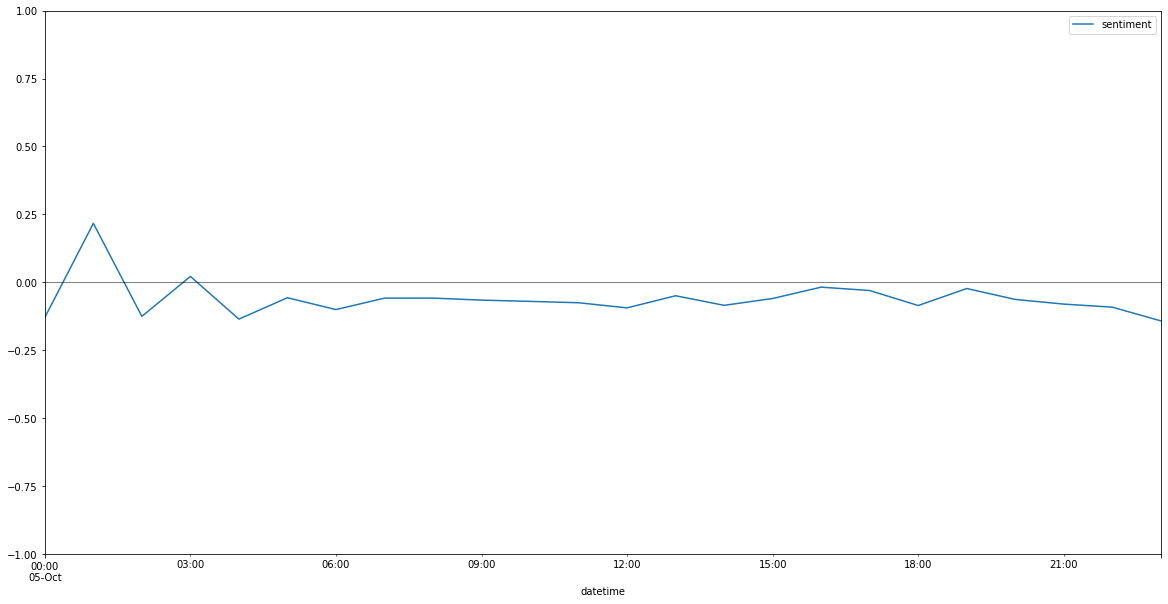

In [17]:
ax = df.groupby(df.index.round("H")).mean().dropna().plot(figsize=(20, 10))
ax.set_ylim(-1, 1)
ax.axhline(0, color="black", linewidth=0.5)
ax

Wieviele Tokens sind Durschnittlich in einer Schlagzeile

In [18]:
df["len_words"] = df["text"].apply(len)
mean_len_words = int(df["len_words"].mean())
mean_len_words

9

Wieviele Zeichen hat eine Schlagzeile im Durchschnitt?

In [19]:
df["len_chars"] = df["text"].apply(str).apply(len)
mean_len_chars = int(df["len_chars"].mean())
mean_len_chars

61

Welches ist die kürzeste Schlagzeile?

In [20]:
df.sort_values("len_chars").head(1)["text"].apply(str)

datetime
2020-10-05 06:50:02    Googles Gaben
Name: text, dtype: object

Welches ist die längste Schlagzeile?

In [21]:
df.sort_values("len_chars", ascending=False).head(1)["text"].apply(str)

datetime
2020-10-05 17:10:03    Feuilletons zerrisen seine Filme - &#034;Dann hab&#039; ich wenigstens was davon&#034;: Wie Til Schweiger von Kritik an seinen Filmen profitiert
Name: text, dtype: object

Gibt es eine Korrelation zwischen der Anzahl der Zeichen und Wörtern?

Der Korrelationskoeffizient kann zwischen `-1` (starke positive Korrelation) und `+1` (starte negative Korrelation) liegen.

In [22]:
df["len_chars"].corr(df["len_words"])

0.825624524964878

Wie verteilt sich die Länge der Schlagzeilen über den gesamten Datensatz?

Das lässt sich mit einem Histogramm am besten visualisieren.

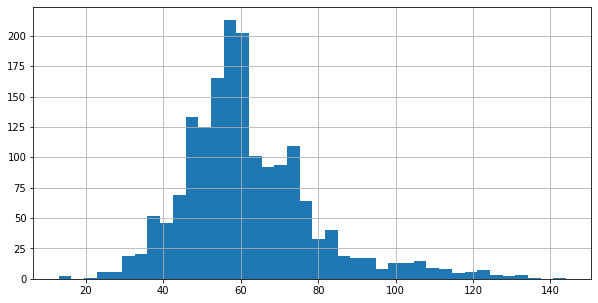

In [23]:
df["len_chars"].hist(figsize=(10, 5), bins=40)

### WÖRTER

Welches sind die Top 20 vorkommenden Wörter?

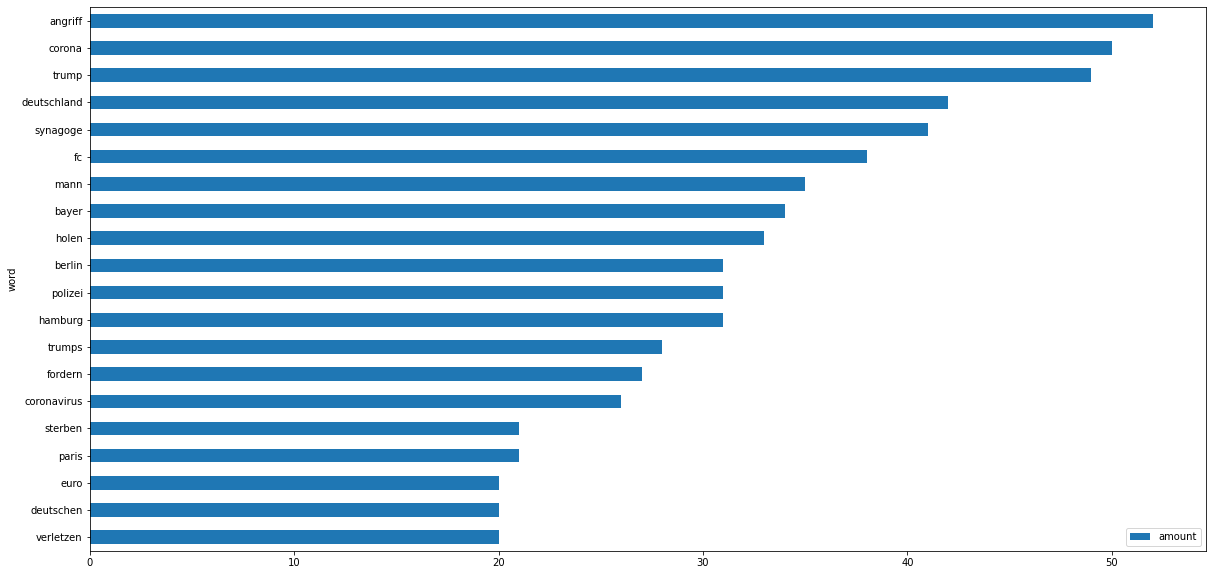

In [40]:
words = [word for l in df["preprocessed"].to_list() for word in l]
c = Counter(words)
top_words = pd.DataFrame.from_records(c.most_common()[:20], columns=["word", "amount"], index="word")
top_words.sort_values("amount").plot.barh(figsize=(20, 10))

### WORD EMBEDDINGS UND PCA

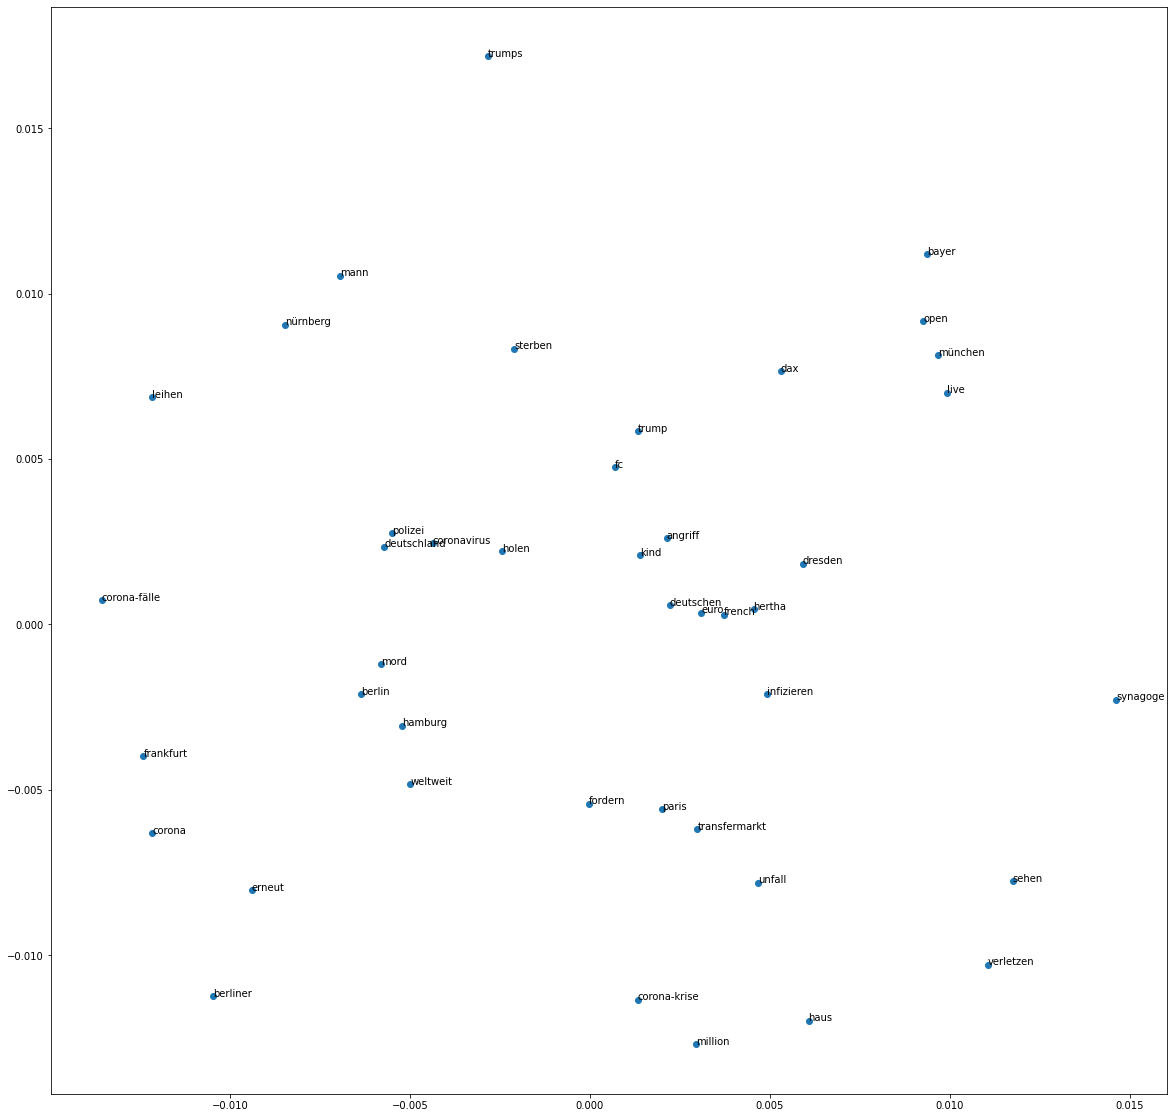

In [105]:
model = Word2Vec(df["preprocessed"].to_list(), max_final_vocab=50, workers=4)
words = list(model.wv.vocab.keys())
vectors = [model.wv[word] for word in words]
pca = PCA(n_components=2)
result = pca.fit_transform(vectors)
X, Y = result.T

fig, ax = plt.subplots(figsize=(20, 20))
ax.scatter(X, Y)
for i, word in enumerate(words):
    ax.annotate(word, (X[i], Y[i]))
ax